In [147]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [148]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [149]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, len(vocab)).shape

torch.Size([5, 2, 28])

In [150]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 允许梯度更新
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)

    return params

In [151]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [152]:
def rnn(inputs, state, params):
    # inputs 的形状：（时间步数量，批量大小，词表大小）
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:    # 按第一个维度遍历 inputs
        # H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        H = F.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)

    outputs = outputs[::-2]
    return torch.cat(outputs, dim=0), (H,)

def rnn_last(inputs, state, params):
    # inputs 的形状：（时间步数量，批量大小，词表大小）
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    for X in inputs:    # 按第一个维度遍历 inputs
        # H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        H = F.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q

    return Y, (H,)

In [153]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [154]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([6, 28]), 1, torch.Size([2, 512]))

In [155]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1)))
    
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [156]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller rbbbbbbbbb'

In [157]:
# 为什么需要梯度裁剪 ？激活函数换成 ReLU 呢 ？
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [158]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
    Y = Y.numpy()[:, ::-2].copy()
    Y = torch.from_numpy(Y)
    y = Y.T.reshape(-1)
    # y = Y[:, -1] # for rnn_last
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
        updater.zero_grad()
        l.backward()
        # grad_clipping(net, 1)
        updater.step()
    else:
        l.backward()
        # grad_clipping(net, 1)
        updater(batch_size=1)

    metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [159]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])

    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller '))
            animator.add(epoch + 1, [ppl])

    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller '))
    print(predict("traveller "))

困惑度 1.4, 33026.0 词元/秒 cuda:0
time traveller tmi that asisenelinn a line of thickness nilhas no
traveller the timn extravogattiy botly of thick cas uncether


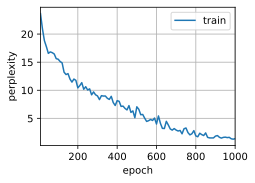

In [160]:
num_epochs, lr = 1000, 1.0
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 37178.9 词元/秒 cuda:0
time traveller smiledtrouggis woul ih t medeooll in thisway marki
traveller tmi an school is founded on a muscenceris in three


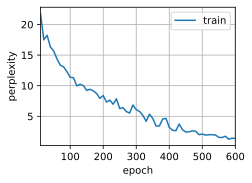

In [161]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
num_epochs, lr = 600, 1.0
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)